# 0. Import

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1️. Load MNIST dataset

In [2]:
print("Loading MNIST dataset...")
start_time = time.time()

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
X, y = mnist.data, mnist.target.astype(int)

print(f"Dataset shape: {X.shape}")  # (70000, 784)
print(f"Labels: {np.unique(y)}")

Loading MNIST dataset...
Dataset shape: (70000, 784)
Labels: [0 1 2 3 4 5 6 7 8 9]


# 2. Split data into train/test sets

In [3]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"Train size: {X_train.shape}, Test size: {X_test.shape}")

Train size: (56000, 784), Test size: (14000, 784)


# 3. Train baseline Random Forest

In [4]:
print("Training baseline Random Forest...")
baseline_start = time.time()

rf_baseline = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
rf_baseline.fit(X_train, y_train)

y_pred_baseline = rf_baseline.predict(X_test)
baseline_accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Baseline Accuracy: {baseline_accuracy:.4f}")

baseline_end = time.time()
print(f"Baseline training + prediction time: {baseline_end - baseline_start:.2f} seconds")

Training baseline Random Forest...
Baseline Accuracy: 0.9689
Baseline training + prediction time: 31.98 seconds


# 4. Fine-tune Random Forest using GridSearchCV

In [5]:
print("Fine-tuning Random Forest...")
tune_start = time.time()

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 20],
    'min_samples_split': [2, 5],
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    param_grid,
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation accuracy: {grid_search.best_score_:.4f}")

tune_end = time.time()
print(f"Grid search time: {tune_end - tune_start:.2f} seconds")

print("Best max_depth:", grid_search.best_params_["max_depth"])


Fine-tuning Random Forest...
Fitting 3 folds for each of 8 candidates, totalling 24 fits
Best parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
Best cross-validation accuracy: 0.9673
Grid search time: 158.60 seconds
Best max_depth: None


# 5. Evaluate Tuned Model

Tuned Random Forest Accuracy: 0.9681

Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      1343
           1       0.99      0.99      0.99      1600
           2       0.96      0.97      0.96      1380
           3       0.96      0.95      0.95      1433
           4       0.96      0.97      0.97      1295
           5       0.97      0.97      0.97      1273
           6       0.98      0.98      0.98      1396
           7       0.97      0.97      0.97      1503
           8       0.96      0.95      0.96      1357
           9       0.95      0.95      0.95      1420

    accuracy                           0.97     14000
   macro avg       0.97      0.97      0.97     14000
weighted avg       0.97      0.97      0.97     14000



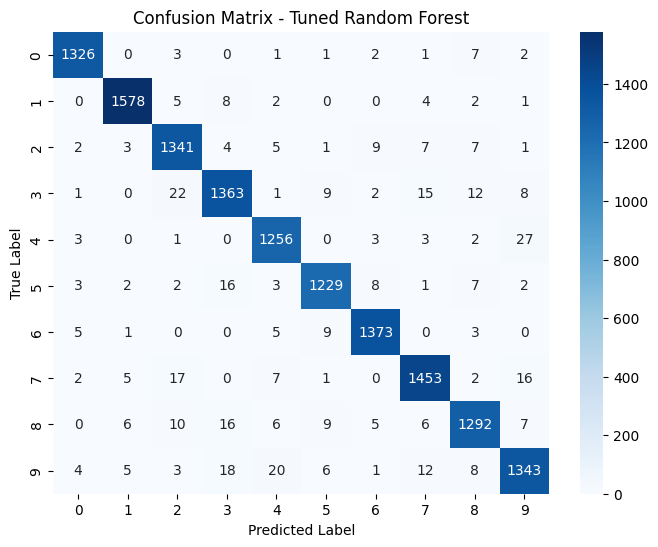

In [6]:
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

accuracy_best = accuracy_score(y_test, y_pred_best)
print(f"Tuned Random Forest Accuracy: {accuracy_best:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_pred_best))

cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Tuned Random Forest")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# 6. Example Predictions

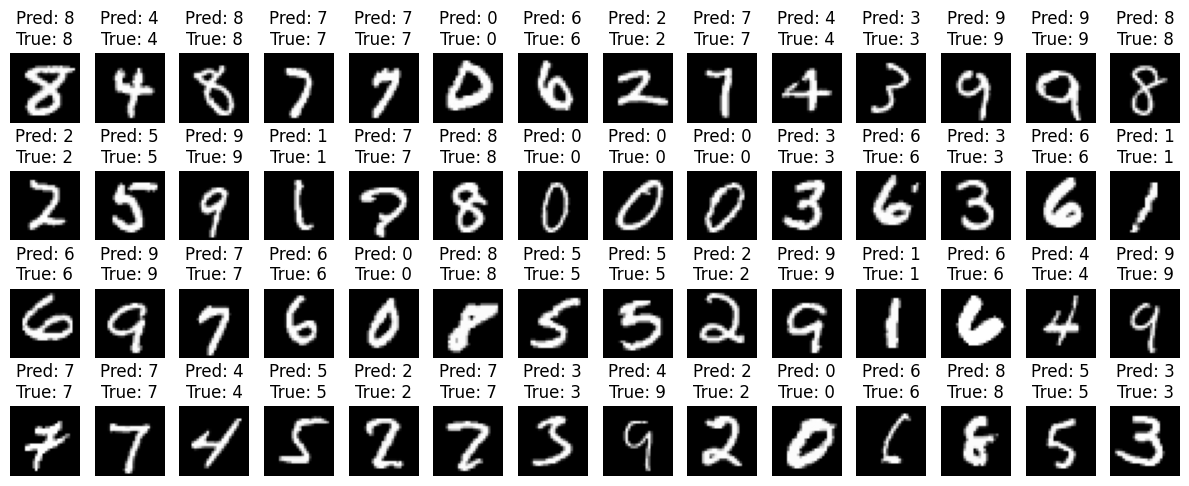

In [7]:
fig, axes = plt.subplots(4, 14, figsize=(12, 5))

for i, ax in enumerate(axes.flat):
    ax.imshow(X_test[i].reshape(28, 28), cmap='gray')
    ax.set_title(f"Pred: {y_pred_best[i]}\nTrue: {y_test[i]}")
    ax.axis('off')

plt.tight_layout()
plt.show()

# 7. Runtime Estimation

In [8]:
total_time = time.time() - start_time

print(f"\nTotal script runtime:\n⏱ {total_time:.2f} seconds")


Total script runtime:
⏱ 195.77 seconds


# 8. Tree Depth Analysis

In [9]:
tree_depths = [estimator.tree_.max_depth for estimator in best_rf.estimators_]
avg_depth = np.mean(tree_depths)
max_depth = np.max(tree_depths)
min_depth = np.min(tree_depths)

print("\n🔍 Tree Depth Analysis:")
print(f"Average tree depth: {avg_depth:.2f}")
print(f"Max tree depth: {max_depth}")
print(f"Min tree depth: {min_depth}")


🔍 Tree Depth Analysis:
Average tree depth: 33.77
Max tree depth: 46
Min tree depth: 26


# 9. Visualize Tree Depth Distribution

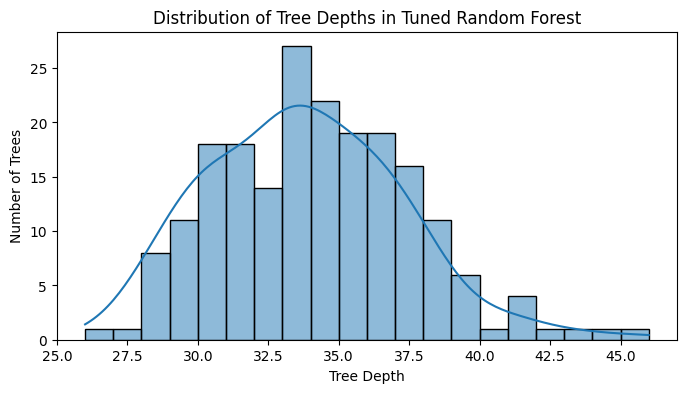

In [10]:
plt.figure(figsize=(8, 4))
sns.histplot(tree_depths, bins=20, kde=True)
plt.title("Distribution of Tree Depths in Tuned Random Forest")
plt.xlabel("Tree Depth")
plt.ylabel("Number of Trees")
plt.show()